# Download Data

In [ ]:
# !wget 'http://ufldl.stanford.edu/housenumbers/extra.tar.gz'
# !tar xvf extra.tar.gz

### Converting .mat file to .csv
The label file is in the .mat format, we shall convert it to a more user-friendly format.

In [ ]:
# !git clone https://github.com/prijip/Py-Gsvhn-DigitStruct-Reader.git
# %cd Py-Gsvhn-DigitStruct-Reader/
# !python digitStructMatToCsv.py ../extra/digitStruct.mat ../ocr.csv

### Inspect Data

In [1]:
from fastai.vision import *
from fastai.text import *

In [2]:
df = pd.read_csv('extra_ocr.csv')
images = get_image_files('extra')

In [3]:
labelled_df = df.groupby('FileName').apply(lambda x: ''.join([str(i) for i in x['DigitLabel']])).to_frame().reset_index(0)
labelled_df.columns = ['filename','labels']

In [4]:
labels = labelled_df['labels'].tolist()
labels_clean = []

for label in labels:
    label = str(label)
    idx = label.find('0')
    if idx != -1:
        if label[idx-1] == '1':
            label = label[:idx-1]+label[idx:]
    labels_clean += [int(label)]

In [5]:
labelled_df['labels'] = labels_clean

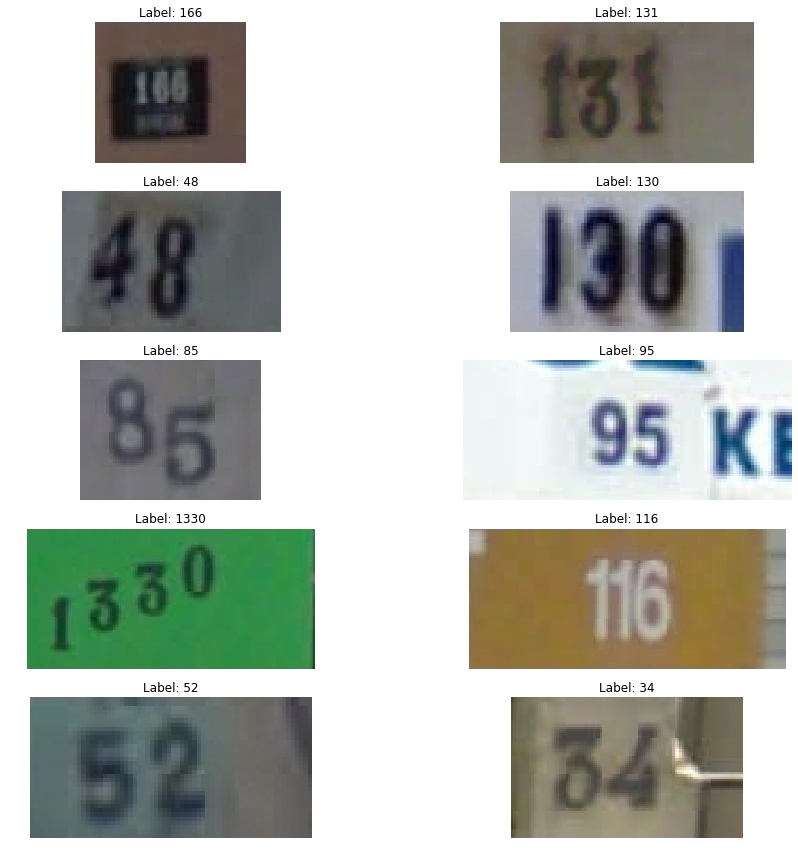

In [6]:
_,axs = plt.subplots(5,2,figsize=(15,15))
axs = axs.flatten()

for i in range(10):
    start = np.random.randint(len(images)-10)

    name = images[start+i].name
    im = open_image(images[start+i])
    im.show(figsize=(6,6),ax=axs[i])
    axs[i].set_title('Label: '+str(labelled_df.loc[labelled_df['filename'] == name]['labels'].item()))

In [8]:
src = ImageList.from_folder('extra').split_by_rand_pct(0.1,seed=42)
train_names = [items.name for items in src.train.items]
val_names = [items.name for items in src.valid.items]
train_order = {v:k for k,v in enumerate(train_names)}
val_order = {v:k for k,v in enumerate(val_names)}
train_df = labelled_df[labelled_df['filename'].isin(train_names)]
valid_df = labelled_df[labelled_df['filename'].isin(val_names)]
train_df['order'] = train_df['filename'].apply(train_order.__getitem__)
train_df = train_df.sort_values('order')

valid_df['order'] = valid_df['filename'].apply(val_order.__getitem__)
valid_df = valid_df.sort_values('order')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
class OCRTokenizer(BaseTokenizer):
    def __init__(self,lang=None):
        pass
    def tokenizer(self,t):
        bos = t[:5]
        eos = t[-5:]
        t = t[5:-5]
        return [bos] + [char for char in t] + [eos]

In [10]:
tok_pre_rules = []
tok_post_rules = []

tok = Tokenizer(tok_func=OCRTokenizer, pre_rules=tok_pre_rules, post_rules=tok_post_rules)

procs = [TokenizeProcessor(tokenizer=tok, include_bos=True, include_eos=True), 
            NumericalizeProcessor(min_freq=1)]

In [12]:
path = './'
label_train_il = TextList.from_df(train_df, path=path, cols=['labels'], processor=procs).process()
label_valid_il = TextList.from_df(valid_df, path=path, cols=['labels'], processor=procs).process()

In [13]:
trn_ll = LabelList(src.train, label_train_il)
val_ll = LabelList(src.valid, label_valid_il)

lls = LabelLists(path, train=trn_ll, valid=val_ll)

In [14]:
def ocr_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        include_targets=True, include_lengths=True, include_masks=True,
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    c,h,w = samples[0][0].shape
    samples.sort(key=lambda x: len(x[1]), reverse=True)
    
    y_lens = [len(s[1]) for s in samples]
    y_max_len = max(y_lens)
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    x_res = torch.zeros(len(samples),c,h,w).float()
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            y_res[i,:len(s[1]):] = LongTensor(s[1])
        x_res[i,:] = tensor(s[0])
            
    return x_res, y_res

In [15]:
data = ImageDataBunch.create_from_ll(lls,size=(48,100),collate_fn=ocr_pad_collate,bs=200).normalize(imagenet_stats)

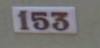

In [17]:
data.valid_ds[2][0]

In [18]:
data.valid_ds[2][1]

Text xxbos   1 5 3   xxeos

# Architecture

In [19]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

In [20]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, nh, **kwargs):
        super().__init__()
        self.cnn = create_body(models.resnet34,pretrained=True)
        self.rnn = nn.Sequential(
                  BidirectionalLSTM(512, nh, nh),
                  BidirectionalLSTM(nh, nh, nh)
        )

    def forward(self,input):
        #get features
        features = self.cnn(input)

        #We want `nc` from convs to be the hidden dim, and `width` to be the `sentence length`
        features = features.mean(-2)
        features = features.permute(2, 0, 1)

        encoder_outputs = self.rnn(features)  # 25×bs×nh

        return encoder_outputs

In [21]:
class AttentionDecoder(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

        # test
        self.vat = nn.Linear(hidden_size, 1)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)        
        embedded = self.dropout(embedded)

        # test
        batch_size = encoder_outputs.shape[1]
        alpha = hidden + encoder_outputs        
        alpha = alpha.view(-1, alpha.shape[-1])
        attn_weights = self.vat( torch.tanh(alpha))                     
        attn_weights = attn_weights.view(-1, 1, batch_size).permute((2,1,0))
        attn_weights = F.softmax(attn_weights, dim=2)

        attn_applied = torch.matmul(attn_weights,
                                 encoder_outputs.permute((1, 0, 2)))     
        
        try:
          output = torch.cat((embedded, attn_applied.squeeze(1) ), 1) 
        except:
          output = torch.cat((embedded.unsqueeze(0), attn_applied.squeeze(1) ), 1) 

        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        ## index into 0 to remove the first dim (it is 1)
        logits = self.out(output) #output logits
        return logits, hidden, attn_weights

    def initHidden(self, batch_size):
        result = Variable(torch.zeros(1, batch_size, self.hidden_size))

        return result
      
class Decoder(nn.Module):
    def __init__(self, nh=256, nclass=13, dropout_p=0.1, teacher_forcing=0.75, max_len=15, pad_idx=1, bos_idx=2):
        super().__init__()
        self.hidden_size = nh
        self.decoder = AttentionDecoder(nh, nclass, dropout_p)
        self.teacher_forcing = 0.5
        self.max_len = max_len
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
    def forward(self, encoded_images, target=None): 
        bs = encoded_images.shape[1]
        decoder_hidden = self.initHidden(bs).cuda()
        decoder_input = encoded_images.new_zeros(bs).long() + self.bos_idx  
        
        outputs = []
        
        for i in range(1, self.max_len):  
            decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoded_images)
            outputs += [decoder_output]

            _, topi = decoder_output.data.topk(1)
            decoder_input = topi.squeeze()
            if (decoder_input==self.pad_idx).all(): break
            if (target is not None) and (random.random()<self.teacher_forcing):
                if i>=target.shape[1]-1: 
                    break
                decoder_input = target[:,i]

              
        return torch.cat(outputs,0).permute(1,0,2)

    def initHidden(self, batch_size):
        result = torch.zeros(1, batch_size, self.hidden_size)
        return result

In [22]:
class OCRModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.encoder = ResNetFeatureExtractor(nh = 256)
        self.decoder = Decoder(256, 24, dropout_p=0.1)
   
      def forward(self,input, target=None):
        encoded = self.encoder(input)
        output = self.decoder(encoded, target)

        return output

In [23]:
def OCR_loss(out, targ, pad_idx=1):
    targ = targ[:,1:]
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

def OCR_acc(out, targ, pad_idx=1):
    targ = targ[:,1:]
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(-1)
    return (out==targ).float().mean()

class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - 0.5 * epoch/self.end_epoch

In [33]:
learn = Learner(data,OCRModel(),loss_func=OCR_loss, metrics=[OCR_acc],callback_fns=partial(TeacherForcing, end_epoch=8))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


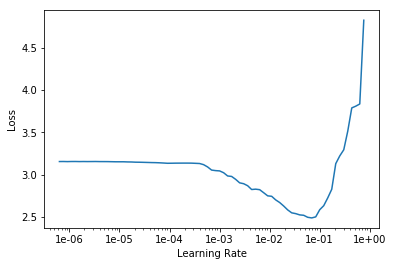

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,OCR_acc,time
0,0.777259,0.868191,0.709788,03:13
1,0.381266,0.429586,0.858476,03:16
2,0.149333,0.205712,0.949022,03:16
3,0.085281,0.116520,0.970279,03:16
4,0.065417,0.106849,0.971160,03:16


In [46]:
learn.save('resnet18-1')

In [49]:
# with open('resnet18_itos.pkl','wb') as f:
#     pickle.dump(data.train_ds.vocab.itos,f)

# Inference

In [38]:
def get_preds(num_preds, rows=2):
    start = np.random.randint(len(data.valid_ds)-num_preds)
    dim = num_preds // rows 
    if num_preds % rows != 0:
        dim += 1
    _ , axs = plt.subplots(dim,rows, figsize=(10,10))
    axs = axs.flatten()  
    for i in range(num_preds):
        x,_= data.valid_ds[start+i]
        input = normalize(x.data,tensor(imagenet_stats[0]),tensor(imagenet_stats[1])).unsqueeze(0)
        res = learn.model(input.cuda())
        outs = [data.train_ds.vocab.itos[i] for i in res.argmax(-1)[0]]
        x.show(ax=axs[i])
        to_print = ''
        for char in outs:
            if char in ['0','1','2','3','4','5','6','7','8','9']:
                to_print += char
        axs[i].title.set_text(f'Prediction: {to_print}')

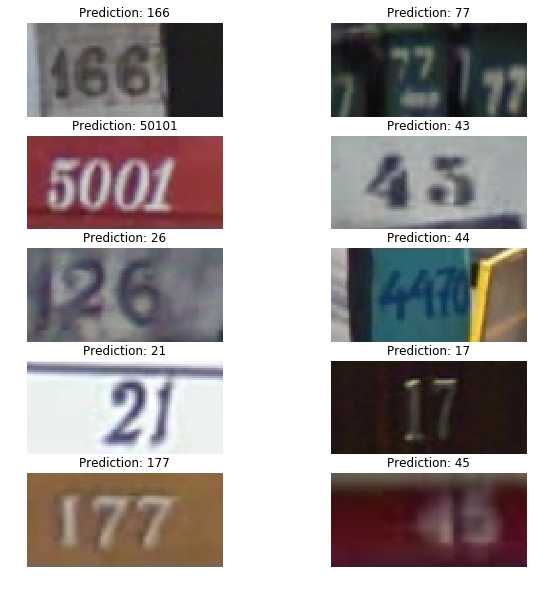

In [39]:
get_preds(10)

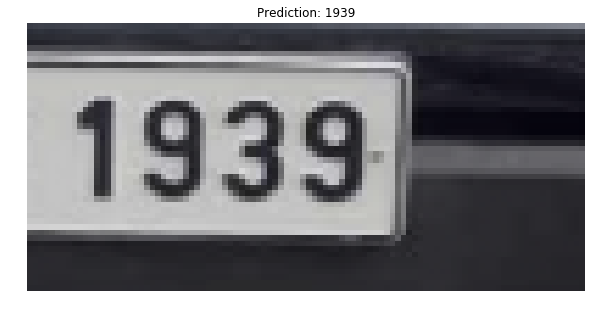

In [45]:
_ , ax = plt.subplots(figsize=(10,10))
x = open_image('plate.png')
x = x.resize((3,48,100))
input = normalize(x.data,tensor(imagenet_stats[0]),tensor(imagenet_stats[1])).unsqueeze(0)
res = learn.model(input.cuda())
outs = [data.train_ds.vocab.itos[i] for i in res.argmax(-1)[0]]
x.show(ax=ax)

to_print = ''
for char in outs:
  if char in ['0','1','2','3','4','5','6','7','8','9']:
    to_print += char
ax.title.set_text(f'Prediction: {to_print}')